Load and pre process **data**

In [2]:
import os
import zipfile
from google.colab import drive

# 📌 Step 1: Mount Google Drive
drive.mount('/content/drive')

# 📌 Step 2: Define Paths
animals_zip_path = "/content/drive/MyDrive/animals10.zip"  # Training + validation (90%)
holdout_zip_path = "/content/drive/MyDrive/holdout.zip"  # Holdout set (10%)

animals_extract_to = "/content/Animals-10/"
holdout_extract_to = "/content/Holdout-10/"

# 📌 Step 3: Extract the ZIP Files
if not os.path.exists(animals_extract_to):
    with zipfile.ZipFile(animals_zip_path, 'r') as zip_ref:
        zip_ref.extractall(animals_extract_to)
    print("✅ Extracted training dataset.")

if not os.path.exists(holdout_extract_to):
    with zipfile.ZipFile(holdout_zip_path, 'r') as zip_ref:
        zip_ref.extractall(holdout_extract_to)
    print("✅ Extracted holdout dataset.")

# 📌 Step 4: Fix Dataset Paths (Point to `raw-img/`)
animals_dataset_path = "/content/Animals-10/animals10/raw-img/"
holdout_dataset_path = "/content/Holdout-10/holdout/raw-img/"

# 📌 Step 5: Check Folder Structure
print("📂 Training Dataset Categories:", os.listdir(animals_dataset_path))
print("📂 Holdout Dataset Categories:", os.listdir(holdout_dataset_path))


Mounted at /content/drive
✅ Extracted training dataset.
✅ Extracted holdout dataset.
📂 Training Dataset Categories: ['cat', '.DS_Store', 'cow', 'dog', 'sheep', 'elephant', 'butterfly', 'squirrel', 'horse', 'chicken', 'spider']
📂 Holdout Dataset Categories: ['cat', '.DS_Store', 'cow', 'dog', 'sheep', 'elephant', 'butterfly', 'squirrel', 'horse', 'chicken', 'spider']


Check the folder structures

In [3]:
# List class folders
print("📂 Classes in Training Dataset:", os.listdir(animals_dataset_path))

# Print the class folders inside the holdout dataset
if os.path.exists(holdout_dataset_path):
    print("📂 Classes in Prediction (Holdout) Dataset:", os.listdir(holdout_dataset_path))
else:
    print("❌ Holdout dataset path not found:", holdout_dataset_path)


📂 Classes in Training Dataset: ['cat', '.DS_Store', 'cow', 'dog', 'sheep', 'elephant', 'butterfly', 'squirrel', 'horse', 'chicken', 'spider']
📂 Classes in Prediction (Holdout) Dataset: ['cat', '.DS_Store', 'cow', 'dog', 'sheep', 'elephant', 'butterfly', 'squirrel', 'horse', 'chicken', 'spider']


Normalize images, rescale and resize, train/validation split, one-hot encode is handled by imageDataGenerator

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalize images and apply data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,  # ✅ Increased rotation
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Load training data
train_generator = datagen.flow_from_directory(
    directory=animals_dataset_path,
    target_size=(128, 128),  # Resize images
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Load validation data
val_generator = datagen.flow_from_directory(
    directory=animals_dataset_path,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

print("Dataset successfully loaded!")


Found 18856 images belonging to 10 classes.
Found 4709 images belonging to 10 classes.
Dataset successfully loaded!


Plot 5 random images

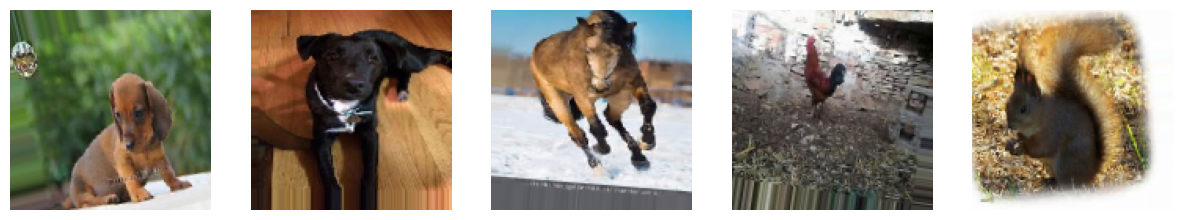

In [5]:
import matplotlib.pyplot as plt

# Get a batch of images
images, labels = next(train_generator)

# Display first 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(images[i])
    axes[i].axis("off")
plt.show()

In [20]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Lambda
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
from keras.regularizers import L1L2
from tensorflow.keras.applications import VGG16
from tensorflow.image import resize


from datetime import datetime
def timestamp():
    return datetime.now().strftime('%y%m%d_%H%M')

# Load the pre-trained model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False
# Check the layer trainable state
for i, layer in enumerate(base_model.layers):
    print(f"{i}. {layer.name}: {layer.trainable}")

# Create a new model on top of VGG16
# Create a new model on top of VGG16
model = Sequential()

# Resize images to 128x128 (the correct input size for VGG16 in your case)
model.add(Lambda(lambda image: resize(image, (128, 128))))  # resize images to 128x128

model.add(base_model)

model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))


0. input_layer_8: False
1. block1_conv1: False
2. block1_conv2: False
3. block1_pool: False
4. block2_conv1: False
5. block2_conv2: False
6. block2_pool: False
7. block3_conv1: False
8. block3_conv2: False
9. block3_conv3: False
10. block3_pool: False
11. block4_conv1: False
12. block4_conv2: False
13. block4_conv3: False
14. block4_pool: False
15. block5_conv1: False
16. block5_conv2: False
17. block5_conv3: False
18. block5_pool: False


In [21]:
# Compile the model with Adam optimizer and binary crossentropy loss

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
lr_schedule = LearningRateScheduler(lambda epoch: 1e-3 * 10**(-epoch / 20))
adam_opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(
    loss='categorical_crossentropy',
    optimizer=adam_opt,
    metrics=['accuracy']
    )

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=60,
    verbose=1,

)



Epoch 1/60
590/590 ━━━━━━━━━━━━━━━━━━━━ 121s 187ms/step - accuracy: 0.4433 - loss: 1.6946 - val_accuracy: 0.7356 - val_loss: 0.8117
Epoch 2/60
590/590 ━━━━━━━━━━━━━━━━━━━━ 103s 174ms/step - accuracy: 0.6466 - loss: 1.0783 - val_accuracy: 0.7585 - val_loss: 0.7309
Epoch 3/60
590/590 ━━━━━━━━━━━━━━━━━━━━ 102s 173ms/step - accuracy: 0.6813 - loss: 0.9563 - val_accuracy: 0.7719 - val_loss: 0.6875
Epoch 4/60
590/590 ━━━━━━━━━━━━━━━━━━━━ 102s 174ms/step - accuracy: 0.6960 - loss: 0.9172 - val_accuracy: 0.7696 - val_loss: 0.6784
Epoch 5/60
590/590 ━━━━━━━━━━━━━━━━━━━━ 102s 174ms/step - accuracy: 0.7081 - loss: 0.8693 - val_accuracy: 0.7821 - val_loss: 0.6468
Epoch 6/60
590/590 ━━━━━━━━━━━━━━━━━━━━ 103s 175ms/step - accuracy: 0.7241 - loss: 0.8254 - val_accuracy: 0.7828 - val_loss: 0.6482
Epoch 7/60
590/590 ━━━━━━━━━━━━━━━━━━━━ 102s 174ms/step - accuracy: 0.7279 - loss: 0.8236 - val_accuracy: 0.7815 - val_loss: 0.6431
Epoch 8/60
590/590 ━━━━━━━━━━━━━━━━━━━━ 103s 174ms/step - accuracy: 0.7418 -

Define Model

# Evaluate Model Performance on Validation Set (NOT on Holdout)

148/148 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - accuracy: 0.7983 - loss: 0.6058
Validation Accuracy: 80.19%
Validation Loss: 0.6093
Training Accuracy: 82.18%
Training Loss: 0.5441


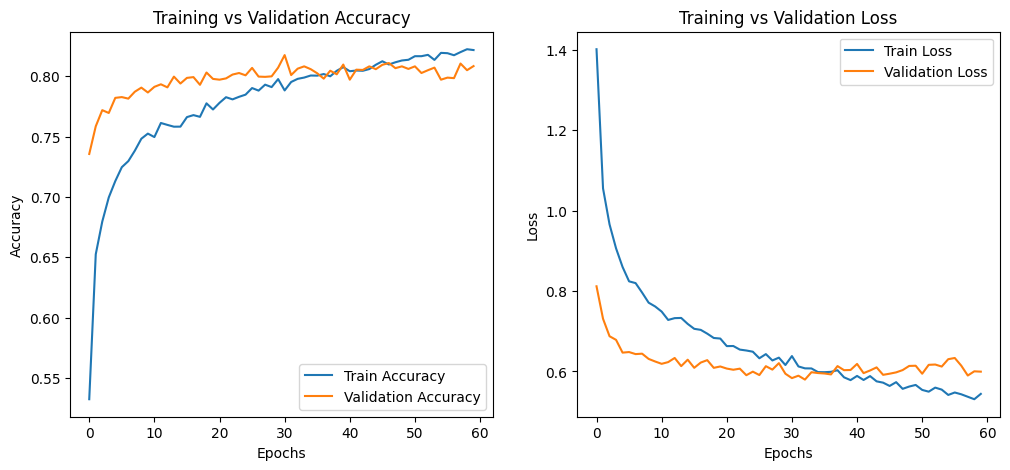

In [22]:
# 📌 Step 10: Evaluate the Model
loss, accuracy = model.evaluate(val_generator)

print(f"Validation Accuracy: {accuracy * 100:.2f}%")
print(f"Validation Loss: {loss:.4f}")

# Get final training accuracy & loss
train_accuracy = history.history['accuracy'][-1]  # Last epoch's accuracy
train_loss = history.history['loss'][-1]  # Last epoch's loss

# Print results
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Training Loss: {train_loss:.4f}")

# 📌 Step 11: Plot Accuracy & Loss Curves
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')

plt.show()

In [ ]:
#Compute and report metrics such as  precision, recall, and F1-score.

Predict on validation set

In [23]:
import numpy as np

# Get true labels and predicted labels
y_true = []
y_pred = []

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Predict on the entire validation set
for images, labels in val_generator:
    predictions = model.predict(images)  # Get predictions
    y_true.extend(np.argmax(labels, axis=1))  # Convert one-hot encoding to label index
    y_pred.extend(np.argmax(predictions, axis=1))  # Get highest probability class

    if len(y_true) >= val_generator.samples:  # Stop when all validation images are processed
        break


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 914ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━

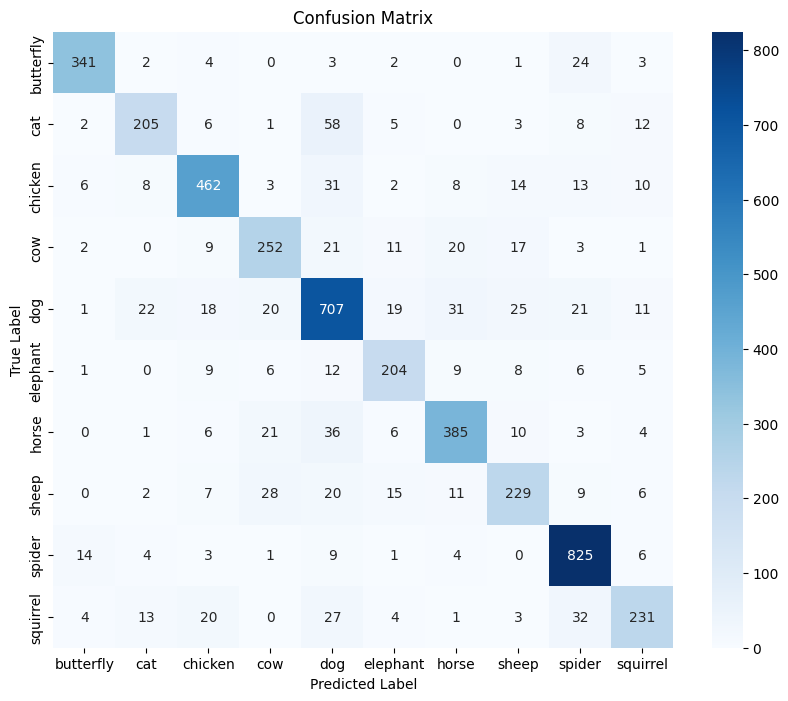

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Predict on Holdout Set (No Evaluation, Only Predictions)


✅ Making Predictions on Holdout Set...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━

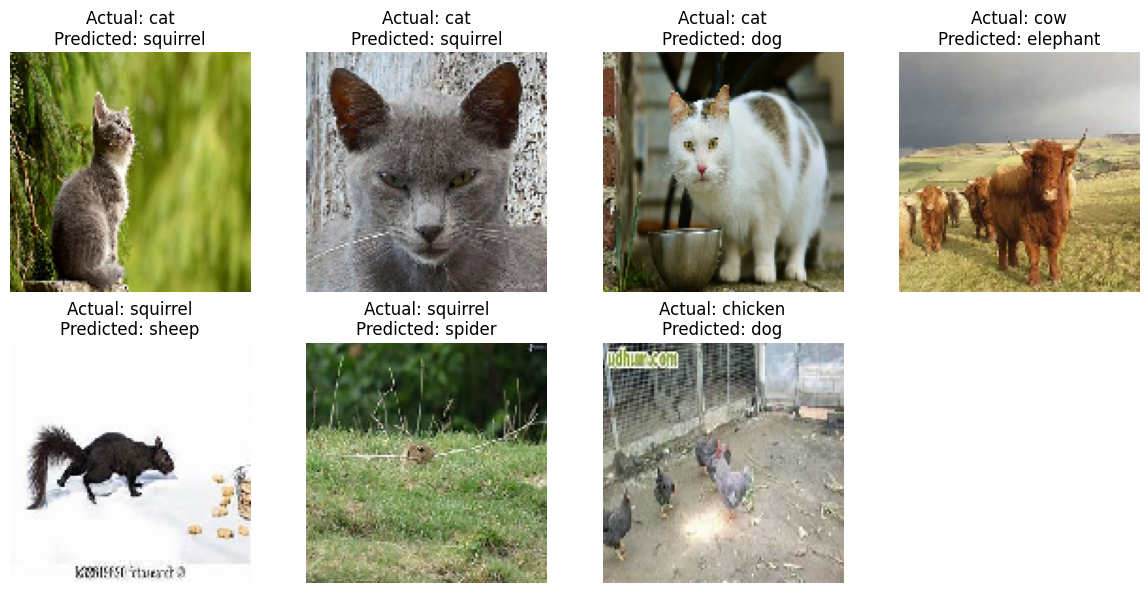

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

print("\n✅ Making Predictions on Holdout Set...")

class_labels = list(train_generator.class_indices.keys())

misclassified_images = []  # Store misclassified images

for class_name in os.listdir(holdout_dataset_path):
    class_folder = os.path.join(holdout_dataset_path, class_name)

    if os.path.isdir(class_folder):
        image_files = os.listdir(class_folder)

        for img_file in image_files[:5]:  # Predict on first 5 images
            if img_file.endswith(('.jpg', '.png', '.jpeg')):  # Ignore `.DS_Store`
                img_path = os.path.join(class_folder, img_file)

                # Load & Preprocess Image
                img = image.load_img(img_path, target_size=(128, 128))
                img_array = image.img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array /= 255.0  # Normalize

                # Make Prediction
                prediction = model.predict(img_array)
                predicted_class = np.argmax(prediction)
                predicted_label = class_labels[predicted_class]

                # Check if misclassified
                if predicted_label != class_name:
                    misclassified_images.append((img_path, class_name, predicted_label))

# 📌 Step 2: Display Misclassified Images
if misclassified_images:
    print(f"\n❌ Found {len(misclassified_images)} Misclassified Images. Displaying...")

    plt.figure(figsize=(12, 6))
    for i, (img_path, actual, predicted) in enumerate(misclassified_images[:8]):  # Show first 8 misclassified images
        img = image.load_img(img_path, target_size=(128, 128))
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Actual: {actual}\nPredicted: {predicted}")

    plt.tight_layout()
    plt.show()
else:
    print("✅ No misclassified images found in the first few samples!")
